In [87]:
import numpy as np
import rocketcea
import matplotlib.pyplot as plt

In [88]:
# Define Inputs

#Engine Core Properties
A = 0.005771714879 #Chamber Area [m^2]
P_c= 3895540 #Chamber Pressure [Pa]
A_t = 0.0006575790181 #Throat Area [m^2]

g = 9.81 #Gravitational Acceleration [m/s^2]
R = 8.314 #Universal Gas Constant [J/mol*K]
pi = 3.14159265359

#Chamber Gas/Geometric Properties
G_c = 1.2409 #Chamber Gas Specific Heat Ratio
T_c = 3048.54 #Chamber Gas Temperature [K]
M_c = 0.019615 #Chamber Gas Molecular Weight [kg/mol]
Cp_c = 2183.2 #Chamber Gas Specific Heat Capacity [J/kg*K]
mu_c = 0.000092148 #Chamber Gas Viscosity [Pa*s]
k_c = 0.35289 #Chamber Gas Thermal Conductivity [W/m*K]
Pr_c = (Cp_c * mu_c)/(k_c) #Chamber Gas Prandtl Number
R_bar_c = R/M_c #Chamber Gas Specific Gas Constant [J/kg*K]

cstar = ((R_bar_c*T_c/G_c) * ((G_c+1)/2)**((G_c+1)/(G_c-1)))**(0.5) #Characteristic Velocity [m/s]
D_t = 2 * (A_t/pi)**(0.5) #Throat Diameter [m]
r_u = 0.00635 #Throat Radius of Curvature [m]

In [181]:
# Bartz Iterator Function Definition
# Initial Condition

def Bartz_Iterator(T_c, T_p, Ma, A, h_p, k_w, t_w):
    T_hwi = 500 #Hot Wall Temperature Initial Guess [K]
    T_res = 1

    while np.abs(T_res) > 0.001:
        T_old = T_hwi
            
        r = Pr_c**0.33 #Recovery Factor
        T_aw = T_c * (((1+(r*(G_c-1)/2)*Ma**2))/((1+((G_c-1)/2)*Ma**2))) #Local Adiabatic Wall Temperature [K]
        s = 1/((((0.5*T_hwi/T_c)*(1+((G_c-1)/2)*Ma**2)+0.5)**0.68)*(1+((G_c-1)/2)*Ma**2)**0.12) #Boundary Layer Correction Factor
        h_g = ((0.026/(D_t**0.2))*((mu_c**0.2) * Cp_c/(Pr_c**0.6))*(P_c/cstar)**0.8 * ((D_t/r_u)**0.1))*((A_t/A)**0.9)*s #Bartz Heat Transfer Coefficient [W/m^2*K]
        q = h_g*(T_aw - T_hwi)

        T_cw = (q/h_p) + T_p
        T_hwi = q*t_w/k_w + T_cw
        T_res = T_hwi-T_old
    return(T_hwi)

Bartz_Iterator(T_c = T_c, T_p = 300, Ma = 0, A = A, h_p = 17435.70437, k_w = 160, t_w = 0.00381)

798.0574127891672

In [92]:
#Define Propellant Inputs

m_dot = 0.1322253981 #Mass Flow Rate [kg/s]
D = 0.002763953196 #Channel Hydraulic Diameter [m]
Cp_p = 2010 #Propellant Specific Heat Capacity [J/kg*K] #Function of Temperature
k_p = 0.125 #Propellant Thermal Conductivity [W/m*k] #Function of Temperature
T_hwi = 789.4597406 #Hot Wall Initial Temperature [K]

In [ ]:
#Testing Cold Side Heat Transfer Calcs
T_px = 300
mu_px = 0.00164 #0.001832*np.exp(-3.0716 + 1.373*(293.15/T_px) + 1.6961*((293.15/T_px)**2)) #Subject to Accuracy Check
Re_Dx = 4*(m_dot)/(3.14*D*mu_px) #Propellant Reynolds Number
Pr_px = (mu_px*Cp_p)/k_p #Propellant Prandtl Number
Nu_Dx = (0.023*(Re_Dx**0.8) * (Pr_px**0.4))
h_px = (k_p/D)*Nu_Dx
print(mu_px, Re_Dx, Pr_px, Nu_Dx, h_px)

0.00164 37159.57120618621 26.371199999999998 385.6881965873478 17442.77893098537


In [ ]:
#Propellant Iterator Function Definition

def Propellant_Iterator(T_hwi, T_p, Ma, A, k_w, t_w, m_dot, D, x):
    T_px = 430 #Propellant Temperature Initial Guess [K]
    T_pres = 1

    while T_pres > 0.001:
        T_pold = T_px

        mu_px = 0.00164 #0.001832*np.exp(-3.0716 + 1.373*(293.15/T_px) + 1.6961*((293.15/T_px)**2)) #Subject to Accuracy Check
        Re_Dx = 4*(m_dot)/(3.14*D*mu_px) #Propellant Reynolds Number
        Pr_px = (mu_px*Cp_p)/k_p #Propellant Prandtl Number
        Nu_Dx = (0.023*(Re_Dx**0.8) * (Pr_px**0.4)) #Nusselt Number
        h_px = (k_p/D)*Nu_Dx

        T_hwx = 500 #Initial Hot Wall Temperature [K]
        T_res = 1

        #Bartz Iterator
        while T_res > 0.001:
            T_old = T_hwx
            
            r = Pr_c**0.33 #Recovery Factor
            T_aw = T_c * (((1+(r*(G_c-1)/2)*Ma**2))/((1+((G_c-1)/2)*Ma**2))) #Local Adiabatic Wall Temperature [K]
            s = 1/((((0.5*T_hwx/T_c)*(1+((G_c-1)/2)*Ma**2)+0.5)**0.68)*(1+((G_c-1)/2)*Ma**2)**0.12) #Boundary Layer Correction Factor
            h_gx = ((0.026/(D_t**0.2))*((mu_c**0.2) * Cp_c/(Pr_c**0.6))*(P_c/cstar)**0.8 * ((D_t/r_u)**0.1))*((A_t/A)**0.9)*s #Bartz Heat Transfer Coefficient [W/m^2*K]
            q = h_gx*(T_aw - T_hwx)

            T_cwx = (q/h_px) + T_px
            T_hwx = q*t_w/k_w + T_cwx
            T_res = np.abs(T_hwx-T_old)

        T_barhw = (T_hwi + T_hwx)/2
        T_barp = (T_px + T_p)/2

        #Average Condition
        s_bar = 1/((((0.5*T_barhw/T_c)*(1+((G_c-1)/2)*Ma**2)+0.5)**0.68)*(1+((G_c-1)/2)*Ma**2)**0.12) #Average Boundary Layer Correction Factor
        h_barg = ((0.026/(D_t**0.2))*((mu_c**0.2) * Cp_c/(Pr_c**0.6))*(P_c/cstar)**0.8 * ((D_t/r_u)**0.1))*((A_t/A)**0.9)*s #Average Bartz Heat Transfer Coefficient [W/m^2*K]

        mu_barp = 0.00164 #0.001832*np.exp(-3.0716 + 1.373*(293.15/T_barp) + 1.6961*((293.15/T_barp)**2)) #Subject to Accuracy Check
        Re_barD = 4*(m_dot)/(3.14*D*mu_barp) #Average Propellant Reynolds Number
        Pr_barp = (mu_barp*Cp_p)/k_p #Average Propellant Prandtl Number
        Nu_barD = (0.023*(Re_barD**0.8) * (Pr_barp**0.4)) #Average Nusselt Number
        h_barp = (k_p/D)*Nu_barD

        U_bar = 1/(1/(h_barg) + (t_w/k_w) + 1/h_barp)
        T_px = np.exp(-(3.14*D*x*U_bar)/(m_dot*Cp_p))*(T_p - T_c) + T_c
        T_pres = np.abs(T_px - T_pold)
    return(T_hwx)

Propellant_Iterator(T_hwi = T_hwi, T_p = 300,  Ma = 0, A = A, k_w = 160, t_w = 0.00381, m_dot = 0.1322253981, D = 0.002763953196, x = 0)


np.float64(797.9483895331758)

In [202]:
#Propellant Iterator Function Definition

def Propellant_Iterator(T_hwi, T_p, Ma, A, k_w, t_w, m_dot, D, x):
    T_px = 430 #Propellant Temperature Initial Guess [K]
    T_pres = 1

    while T_pres > 0.001:
        T_pold = T_px

        mu_px = 0.00164 #0.001832*np.exp(-3.0716 + 1.373*(293.15/T_px) + 1.6961*((293.15/T_px)**2)) #Subject to Accuracy Check
        Re_Dx = 4*(m_dot)/(3.14*D*mu_px) #Propellant Reynolds Number
        Pr_px = (mu_px*Cp_p)/k_p #Propellant Prandtl Number
        Nu_Dx = (0.023*(Re_Dx**0.8) * (Pr_px**0.4)) #Nusselt Number
        h_px = (k_p/D)*Nu_Dx

        T_hwx = 500 #Initial Hot Wall Temperature [K]
        T_res = 1

        #Bartz Iterator
        while T_res > 0.001:
            T_old = T_hwx
            
            r = Pr_c**0.33 #Recovery Factor
            T_aw = T_c * (((1+(r*(G_c-1)/2)*Ma**2))/((1+((G_c-1)/2)*Ma**2))) #Local Adiabatic Wall Temperature [K]
            s = 1/((((0.5*T_hwx/T_c)*(1+((G_c-1)/2)*Ma**2)+0.5)**0.68)*(1+((G_c-1)/2)*Ma**2)**0.12) #Boundary Layer Correction Factor
            h_gx = ((0.026/(D_t**0.2))*((mu_c**0.2) * Cp_c/(Pr_c**0.6))*(P_c/cstar)**0.8 * ((D_t/r_u)**0.1))*((A_t/A)**0.9)*s #Bartz Heat Transfer Coefficient [W/m^2*K]
            q = h_gx*(T_aw - T_hwx)

            T_cwx = (q/h_px) + T_px
            T_hwx = q*t_w/k_w + T_cwx
            T_res = np.abs(T_hwx-T_old)

        T_barhw = (T_hwi + T_hwx)/2
        T_barp = (T_px + T_p)/2

        #Average Condition
        s_bar = 1/((((0.5*T_barhw/T_c)*(1+((G_c-1)/2)*Ma**2)+0.5)**0.68)*(1+((G_c-1)/2)*Ma**2)**0.12) #Average Boundary Layer Correction Factor
        h_barg = ((0.026/(D_t**0.2))*((mu_c**0.2) * Cp_c/(Pr_c**0.6))*(P_c/cstar)**0.8 * ((D_t/r_u)**0.1))*((A_t/A)**0.9)*s #Average Bartz Heat Transfer Coefficient [W/m^2*K]

        mu_barp = 0.00164 #0.001832*np.exp(-3.0716 + 1.373*(293.15/T_barp) + 1.6961*((293.15/T_barp)**2)) #Subject to Accuracy Check
        Re_barD = 4*(m_dot)/(3.14*D*mu_barp) #Average Propellant Reynolds Number
        Pr_barp = (mu_barp*Cp_p)/k_p #Average Propellant Prandtl Number
        Nu_barD = (0.023*(Re_barD**0.8) * (Pr_barp**0.4)) #Average Nusselt Number
        h_barp = (k_p/D)*Nu_barD

        U_bar = 1/(1/(h_barg) + (t_w/k_w) + 1/h_barp)
        T_px = np.exp(-(3.14*D*x*U_bar)/(m_dot*Cp_p))*(T_p - T_c) + T_c
        T_pres = np.abs(T_px - T_pold)
    return(T_hwx)

Propellant_Iterator(T_hwi = T_hwi, T_p = 300,  Ma = 0, A = A, k_w = 160, t_w = 0.00381, m_dot = m_dot, D = D, x = 0)

np.float64(797.9483895331758)

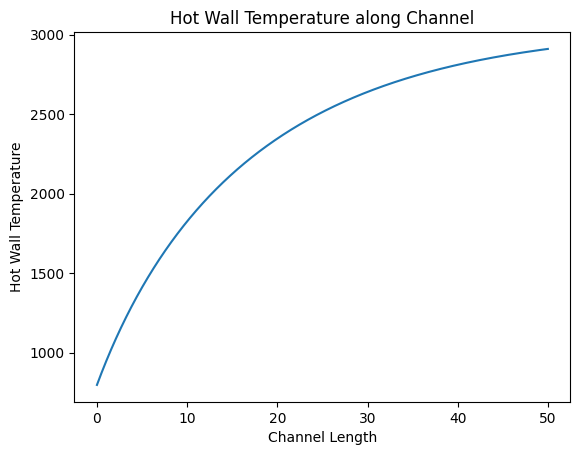

In [203]:
def Regen(D_ch,L_ch,m_dotp):
    xlist = np.arange(0,L_ch,0.01)
    ylist = [Propellant_Iterator(T_hwi = T_hwi, T_p = 300,  Ma = 0, A = A, k_w = 160, t_w = 0.00381, m_dot = m_dotp, D = D_ch, x = float(xi)) for xi in xlist]

    plt.plot(xlist, ylist)
    plt.title('Hot Wall Temperature along Channel')
    plt.xlabel('Channel Length')
    plt.ylabel('Hot Wall Temperature')

Regen(D_ch = 0.002763953196, L_ch = 50, m_dotp = 0.1322253981)